In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all the necessary packages for pretraining

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, MaxPooling2D, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.optimizers import Adam, SGD 

In [3]:
import json
import numpy as np
import argparse
import os 
from os.path import isfile, join
import matplotlib.pyplot as plt
import h5py
import random
import pickle

Check whether there are any GPUs available

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Check the TF verison and h5py version

In [5]:
print("TF version is:",tf.__version__)
print("h5py version is:",h5py.__version__)

TF version is: 2.8.0
h5py version is: 3.1.0


Load the German dataset. The German dataset has already been separated into train/set/validaiton sets and has been stored in json files as dictionaries. Observe that same patient is only in one of trainin/test/validation set and not in two or three of them. 

In [6]:
with open('/content/drive/MyDrive/CS230_Code_Data/OLD/german_data_correctly_split_train.json', 'rb') as fp:
    dataset_train = pickle.load(fp)

with open('/content/drive/MyDrive/CS230_Code_Data/OLD/german_data_correctly_split_val.json', 'rb') as fp:
    dataset_val = pickle.load(fp)

with open('/content/drive/MyDrive/CS230_Code_Data/OLD/german_data_correctly_split_test.json', 'rb') as fp:
    dataset_test = pickle.load(fp)

Use the numpy arrays in the dictionaries imported above to create trainin/test/validation sets as numpy matrices which has appropriate type to be used in Keras training and testing

In [7]:
def create_dataset(dataset):
    X = []
    y = []

    for person in dataset:
        spectogram = person['spectogram']  #/np.float32(255)
        status = int(person['status'])   # Look whether the person is pathalogical or not
        X.append(spectogram)
        y.append(status)

    X = np.array(X)
    y = np.array(y)

    y = y.reshape((len(dataset),1))
    #X = X.reshape((296, 28, 28, 1))
    print('X shape: ', X.shape, ',y shape: ', y.shape)
    return X, y

In [8]:
train_data, train_label = create_dataset(dataset_train)
test_data, test_label = create_dataset(dataset_test)
val_data, val_label = create_dataset(dataset_val)

X shape:  (2912, 224, 224, 3) ,y shape:  (2912, 1)
X shape:  (550, 224, 224, 3) ,y shape:  (550, 1)
X shape:  (620, 224, 224, 3) ,y shape:  (620, 1)


In [9]:
print('The ratio of training set is:', train_data.shape[0] / (train_data.shape[0] + test_data.shape[0] + val_data.shape[0]))

The ratio of training set is: 0.7133757961783439


Construct the CNN model that is going to be used for training and as pre-trained model for the Stanford dataset later on. 

In [10]:
initializer = tf.keras.initializers.GlorotNormal() # Xavier initialization

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), name = 'conv_1', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same', name = 'conv_2', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same', name= 'conv_3', kernel_initializer=initializer))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same', name= 'conv_4'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.AveragePooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='elu', name='Dense_layer'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 56, 56, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 16)       64        
 hNormalization)                                                 
                                                        

See the model in graph form as well:

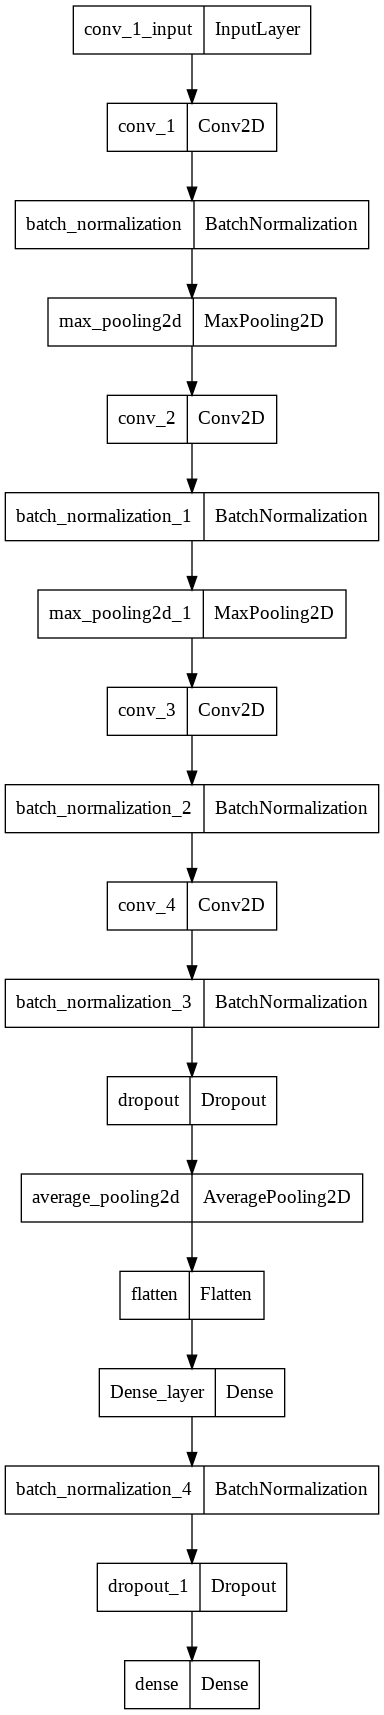

In [11]:
tf.keras.utils.plot_model(model)

Compile the model with Adam optimizer with lr=5e-5 and using weighted binary cross entropy as loss function. 

In [12]:
opt = Adam(learning_rate=5e-5)
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [13]:
history = model.fit(train_data, train_label, epochs=40, validation_data=(val_data,val_label), class_weight={0:1.5, 1:1})

Epoch 1/40
91/91 [==============================] - 16s 34ms/step - loss: 0.9929 - accuracy: 0.5326 - precision: 0.6717 - recall: 0.5578 - val_loss: 0.6527 - val_accuracy: 0.6790 - val_precision: 0.7071 - val_recall: 0.9315
Epoch 2/40
91/91 [==============================] - 2s 26ms/step - loss: 0.9746 - accuracy: 0.5182 - precision: 0.6660 - recall: 0.5278 - val_loss: 0.7173 - val_accuracy: 0.4726 - val_precision: 0.7322 - val_recall: 0.3995
Epoch 3/40
91/91 [==============================] - 2s 25ms/step - loss: 0.9476 - accuracy: 0.5374 - precision: 0.6883 - recall: 0.5347 - val_loss: 0.6837 - val_accuracy: 0.5532 - val_precision: 0.7605 - val_recall: 0.5365
Epoch 4/40
91/91 [==============================] - 2s 25ms/step - loss: 0.9473 - accuracy: 0.5402 - precision: 0.6840 - recall: 0.5515 - val_loss: 0.6732 - val_accuracy: 0.5742 - val_precision: 0.7620 - val_recall: 0.5776
Epoch 5/40
91/91 [==============================] - 2s 26ms/step - loss: 0.9170 - accuracy: 0.5477 - precis

Save the accuracy values in lists

In [14]:
acc_first_train = history.history["accuracy"]
acc_first_val = history.history["val_accuracy"]

Decrease the learning rate and train for a few more epochs

In [15]:
opt = Adam(learning_rate=1e-5)
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
history = model.fit(train_data, train_label, epochs=40, validation_data=(val_data,val_label), class_weight={0:1.2, 1:1}) # May be increase epochs since the val loss still is decreasing

Epoch 1/40
91/91 [==============================] - 4s 31ms/step - loss: 0.6765 - accuracy: 0.6569 - precision_1: 0.7614 - recall_1: 0.6922 - val_loss: 0.5776 - val_accuracy: 0.7081 - val_precision_1: 0.8009 - val_recall_1: 0.7808
Epoch 2/40
91/91 [==============================] - 2s 26ms/step - loss: 0.6752 - accuracy: 0.6604 - precision_1: 0.7625 - recall_1: 0.6980 - val_loss: 0.5840 - val_accuracy: 0.6952 - val_precision_1: 0.8015 - val_recall_1: 0.7557
Epoch 3/40
91/91 [==============================] - 2s 25ms/step - loss: 0.6738 - accuracy: 0.6442 - precision_1: 0.7509 - recall_1: 0.6822 - val_loss: 0.5835 - val_accuracy: 0.6871 - val_precision_1: 0.7961 - val_recall_1: 0.7489
Epoch 4/40
91/91 [==============================] - 2s 25ms/step - loss: 0.6727 - accuracy: 0.6484 - precision_1: 0.7535 - recall_1: 0.6870 - val_loss: 0.5954 - val_accuracy: 0.6758 - val_precision_1: 0.8046 - val_recall_1: 0.7146
Epoch 5/40
91/91 [==============================] - 2s 26ms/step - loss: 0.6

In [16]:
acc_second_train = history.history["accuracy"]
acc_second_val = history.history["val_accuracy"]

In [17]:
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_data, test_label)
print('The accuracy on the test set for the German dataset is:', test_acc)
print('The recall on the test set for the German dataset is:', test_recall)
print('The precision on the test set for the German dataset is:', test_prec)
print('The F1-score on the test set for the German dataset is:', (2*test_prec*test_recall)/(test_prec+test_recall))

18/18 [==============================] - 0s 16ms/step - loss: 0.5798 - accuracy: 0.7127 - precision_1: 0.7905 - recall_1: 0.7732
acc: 0.7127272486686707
recall: 0.7732240557670593
precision: 0.7905027866363525


In [18]:
model.save_weights('/content/drive/MyDrive/CS230_Code_Data/Dataset/german_model.h5')

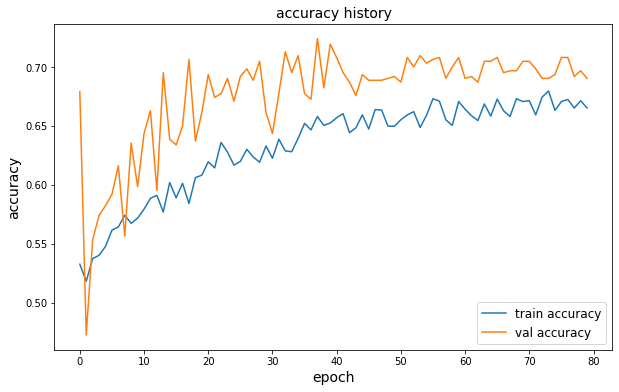

In [19]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10,6))
acc_train = acc_first_train + acc_second_train
acc_val = acc_first_val + acc_second_val
plt.plot(acc_train, label="train accuracy")
plt.plot(acc_val, label="val accuracy")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('accuracy history', fontsize=14)
plt.legend(fontsize='large')

f.savefig('accuracy_history_german.pdf', bbox_inches='tight')